# Default of Credit Card Clients - Predictive Models

# Outline

- Introduction
- Read data and check data structure
- Data exploration
- Predictive models
- Model evaluation

# Introduction

This dataset contains information on credit card holders. The objective is to estimate the probability of default. 

We will talk about the content of the data.

## Load libaries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline 

import gc
from datetime import datetime 

pd.set_option('display.max_columns', 100)

import seaborn as sns
import matplotlib as mpl

from numpy import convolve

from sklearn.model_selection import train_test_split
import xgboost as xgb


import traceback
import scipy.stats.stats as stats
import re
from pandas import Series
import pandas.core.algorithms as algos
from bayes_opt import BayesianOptimization

#Ignore warnings 
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve,  roc_auc_score, precision_recall_curve
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb


## Read data and check data structure

In [2]:
data_path = './default of credit card clients.xls'
data_pd = pd.read_excel(data_path,header=[1])
print("Default Credit Card Clients data -  rows:",data_pd.shape[0]," columns:", data_pd.shape[1])
data_pd.head(5)

Default Credit Card Clients data -  rows: 30000  columns: 25


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
data_pd_des = data_pd.describe()
data_pd_des

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


## Data exploration

### Demographic factors distribution

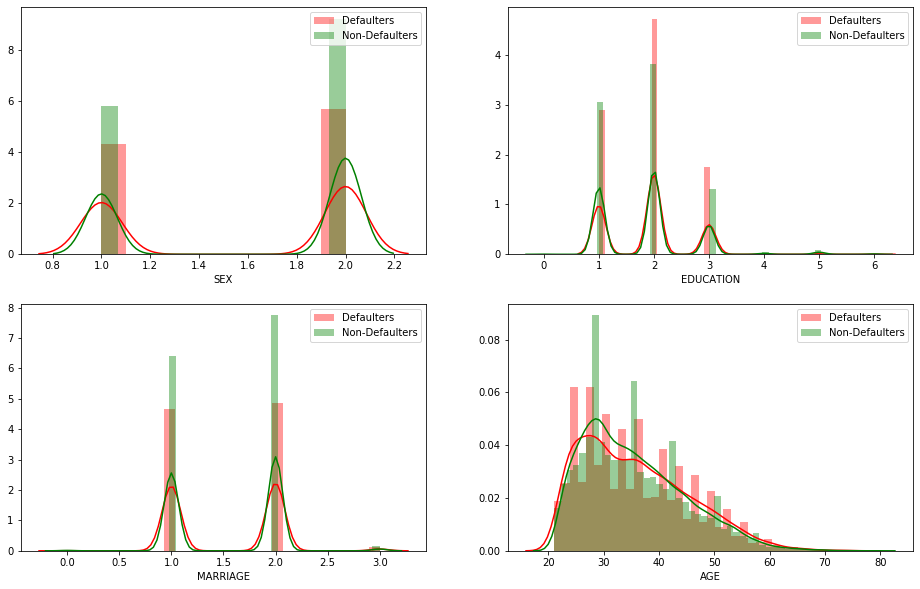

In [4]:
TARGET = 'default payment next month'
fig, axs = plt.subplots(2,2,figsize=(16,10))
demographic = ['SEX', 'EDUCATION', 'MARRIAGE', 'AGE']
for i in range(4):
    class_0 = data_pd.loc[data_pd[TARGET] == 0][demographic[i]]
    class_1 = data_pd.loc[data_pd[TARGET] == 1][demographic[i]]
    sns.distplot(class_1,kde=True, color="red",ax=axs[i//2][i%2])
    sns.distplot(class_0,kde=True, color="green",ax=axs[i//2][i%2])
    axs[i//2][i%2].legend(labels=['Defaulters','Non-Defaulters'],
           loc='upper right',bbox_to_anchor=(1, 1))
plt.show();

**Observation:** Demographic factors Doesn't seem to be key differentiating factors

### Amount of credit limit distribution

Let's look at the amount of credit limit distribution for defaulters and non-defaulters.

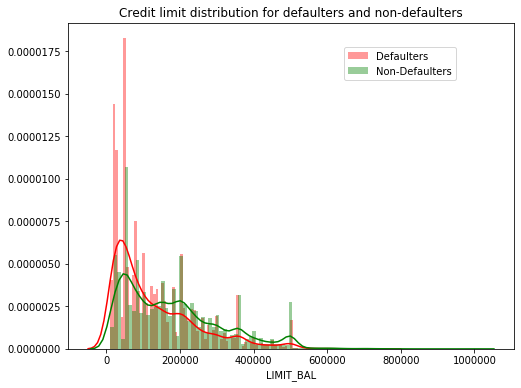

In [5]:
class_0 = data_pd.loc[data_pd[TARGET] == 0]["LIMIT_BAL"]
class_1 = data_pd.loc[data_pd[TARGET] == 1]["LIMIT_BAL"]
fig=plt.figure(figsize = (8,6))
plt.title('Credit limit distribution for defaulters and non-defaulters')
sns.set_color_codes("pastel")
sns.distplot(class_1,kde=True,bins=100, color="red")
sns.distplot(class_0,kde=True,bins=100, color="green")
fig.legend(labels=['Defaulters','Non-Defaulters'],
           loc='upper right',bbox_to_anchor=(0.8, 0.8))
plt.show();

**Observation:** Defaulter/non-defaulters ratio is larger at the lower credit limit

### Re-payment status distribution

Let's look at the Re-payment status distribution for defaulters and non-defaulters. 

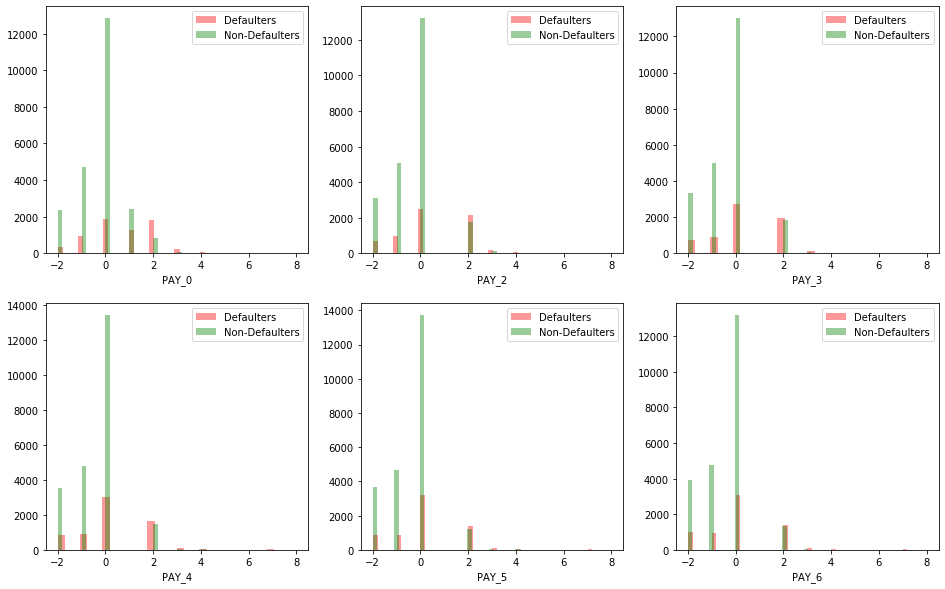

In [6]:
fig, axs = plt.subplots(2,3,figsize=(16,10))
pay_status = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

for i in range(6):
    class_0 = data_pd.loc[data_pd[TARGET] == 0][pay_status[i]]
    class_1 = data_pd.loc[data_pd[TARGET] == 1][pay_status[i]]
    sns.distplot(class_1,kde=False, color="red",ax=axs[i//3][i%3])
    sns.distplot(class_0,kde=False, color="green",ax=axs[i//3][i%3])
    axs[i//3][i%3].legend(labels=['Defaulters','Non-Defaulters'],
           loc='upper right',bbox_to_anchor=(1, 1))
plt.show();

**Observation**: Across all months, defaulters generally tend to pay two months late, non-defaulters generally pay within a month.



### Bill amount and pay amount

In [7]:
data_pd['PAY2BILL'] = (data_pd['PAY_AMT1']/(data_pd['BILL_AMT2']+1e-10)+
                       data_pd['PAY_AMT2']/(data_pd['BILL_AMT3']+1e-10)+
                       data_pd['PAY_AMT3']/(data_pd['BILL_AMT4']+1e-10)+
                       data_pd['PAY_AMT4']/(data_pd['BILL_AMT5']+1e-10)+
                       data_pd['PAY_AMT5']/(data_pd['BILL_AMT6']+1e-10))/5.0

Text(0.5, 1.0, 'PAY_AMT / BILL_AMT ratio distribution for defaulters and non-defaulters')

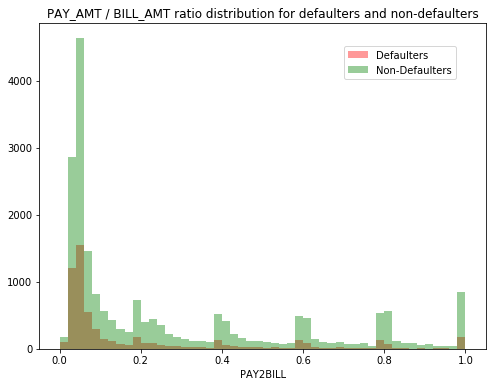

In [8]:
class_0 = data_pd.loc[(data_pd["PAY2BILL"]>0) & (data_pd["PAY2BILL"]<1) & (data_pd[TARGET] == 0)]['PAY2BILL']
class_1 = data_pd.loc[(data_pd["PAY2BILL"]>0) & (data_pd["PAY2BILL"]<1) & (data_pd[TARGET] == 1)]['PAY2BILL']
fig=plt.figure(figsize = (8,6))
plt.title('PAY_AMT / BILL_AMT ratio distribution for defaulters and non-defaulters')
sns.set_color_codes("pastel")
sns.distplot(class_1,kde=False, bins =50, color='red')
sns.distplot(class_0,kde=False, bins =50, color='green')
fig.legend(labels=['Defaulters','Non-Defaulters'],
           loc='upper right',bbox_to_anchor=(0.8, 0.8))
plt.show();
data_pd.drop(columns=['PAY2BILL'],inplace=True)

In [9]:
print('Number of samples used for the above distribution plot: ')
print('(class 0: {})'.format(len(class_0)) + ' and ' + '(class 1: {})'.format(len(class_1)))

Number of samples used for the above distribution plot: 
(class 0: 20327) and (class 1: 5783)


**Observation:** Interestingly, clients tend not to pay the whole amount of the bill. Most of them willing to pay 5% of the bill amount, and others willing to pay roughly 20%, 40%, 60%, 80%, and 100% of the bill amount. 

**Observations:**
  * There is no missing value in the data
  * Education level is mostly graduate school and university
  * Most of the clients are either married or single
  * Average age is 35.5
  * Overall default rate is 22%, according to target variable mean

# Data preprocessing

## Train-validation split 

In [10]:
VALID_SIZE = 0.20 # simple validation using train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation

RANDOM_STATE = 2020

train_df, val_df = train_test_split(data_pd, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

# Make copies of the train_df and val_df for later usage.
train_df_bkp = train_df.copy()
val_df_bkp = val_df.copy()

X_train, y_train = train_df.iloc[:,1:-1], train_df.iloc[:,-1]
X_test,  y_test  = val_df.iloc[:,1:-1],  val_df.iloc[:,-1]

y_train_hist,  y_test_hist = y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

print('In the training dataset, the default rate is')
print('{:.2f}'.format(y_train_hist[1]/(y_train_hist[0]+y_train_hist[1])))
print('In the validation dataset, the default rate is')
print('{:.2f}'.format(y_test_hist[1]/(y_test_hist[0]+y_test_hist[1])))

print('The default rates are similar in the training and validation dataset')

In the training dataset, the default rate is
0.22
In the validation dataset, the default rate is
0.23
The default rates are similar in the training and validation dataset


## Feature Engineer

Weight of Evidence and information value is a common statistic used in classification models to gauge the predictive power of your feature set. Let's now do Weight of Evidence transformation.

In [11]:
max_bin = 20
force_bin = 3

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

def woe_trans(df, final_iv):
    df_woe = df.copy(deep=True)
    for column in df.columns:
        dvar = df_woe[column]
        var_woe = final_iv[final_iv['VAR_NAME']==column][['MIN_VALUE','MAX_VALUE','WOE']]
        var_woe.reset_index(drop=True, inplace=True)
        split_list = [[var_woe['MIN_VALUE'][k], var_woe['MAX_VALUE'][k]] for k in range(len(var_woe))]
        for i in range(len(var_woe)):
            dvar[(dvar>=split_list[i][0]) & (dvar <=split_list[i][1])] = var_woe['WOE'][i]
    return df_woe

# Define a binning function for continuous independent variables
def mono_bin(Y, X, n = max_bin):
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

# Define a binning function for categorical independent variables
def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
 
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

In [12]:
# Fit on the train data
final_iv, IV = data_vars(X_train,y_train)

# Transform on train and test data
X_train = woe_trans(X_train, final_iv)
X_test = woe_trans(X_test, final_iv)


In [13]:
mm_scaler = preprocessing.MinMaxScaler()

X_train_mm = mm_scaler.fit_transform(X_train)
X_test_mm = mm_scaler.transform(X_test)

# MinMaxScalar changed dataset type to be array, we change it back
X_train = pd.DataFrame(X_train_mm, index=X_train.index, columns=X_train.columns)
X_test  = pd.DataFrame(X_test_mm,  index=X_test.index,  columns=X_test.columns)



In [14]:
from warnings import filterwarnings
from sklearn.model_selection import GridSearchCV
filterwarnings('ignore')

param_grid = [
    {'penalty':  ['l2'],
     'C':        [0.1, 1, 10, 100, 1000, 10000], 
     'max_iter': [10, 100, 1000, 10000],
     'tol':      [1e-4, 1e-5, 1e-6],
     'solver':   ['newton-cg']
    },
    {'penalty':  ['l1'],
     'C':        [0.1, 1, 10, 100, 1000, 2000], 
     'max_iter': [10, 100, 1000],
     'tol':      [1e-4, 1e-5, 1e-6],
     'solver':   ['saga']
    },
]
lgt_clf = LogisticRegression()
grid_search = GridSearchCV(lgt_clf, param_grid, cv=5, iid='True', 
                           scoring='f1')
grid_search.fit(X_train, y_train)

# Best params
print(grid_search.best_params_)

# Best estimator
lgt_clf_gd=grid_search.best_estimator_;

{'C': 10, 'max_iter': 10, 'penalty': 'l1', 'solver': 'saga', 'tol': 1e-05}


In [15]:
lgt_clf_gd.fit(X_train, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=1e-05, verbose=0,
                   warm_start=False)

<Figure size 2250x750 with 0 Axes>

Text(0.5, 1.0, 'Logistic Regression')

Text(0.55, 0.45, 'Logsticgb F1 score:       0.539')

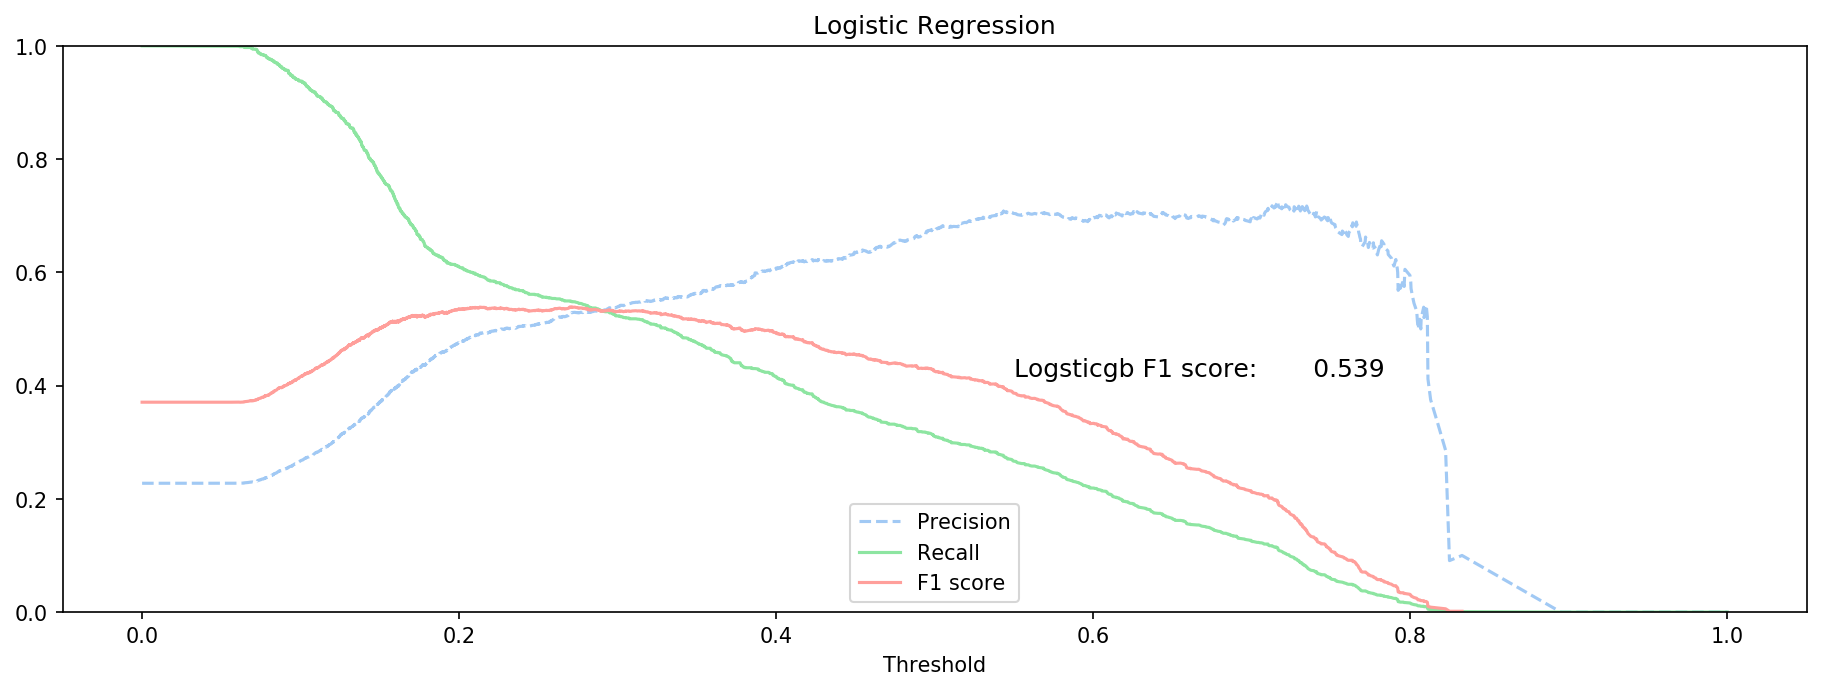

In [16]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, 'g-', linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    f1=2*recalls*precisions/(precisions+recalls)
    plt.plot(thresholds, f1[:-1], "r-", label="F1 score")
    plt.xlabel("Threshold")
    plt.legend(loc="lower center")
    plt.ylim([0, 1])

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=12)
    plt.ylabel("Precision", fontsize=12)
    plt.axis([0, 1, 0, 1])


y_test_pred_prob_lgt_gd = lgt_clf_gd.predict_proba(X_test)[:,1]


pl2, rl2, tl2 = precision_recall_curve(y_test, y_test_pred_prob_lgt_gd)



f1=2*pl2*rl2/(pl2+rl2)

mpl.rcParams['figure.dpi']= 150
plt.figure(figsize=(15,5))


plot_precision_recall_vs_threshold(pl2, rl2, tl2 );
plt.title('Logistic Regression')


txt_f1 = 'Logsticgb F1 score:  %10.3f'%(np.nanmax(f1[:-1]))

#plt.text(0.55, 0.45, txt_f1, fontsize=12, va='top')
plt.text(0.55, 0.45, txt_f1, fontsize=12, va='top')


<Figure size 400x400 with 0 Axes>

Text(0.5, 1.0, 'Test data ROC')

Text(0.55, 0.45, 'Logstic AUC:       77.06%')

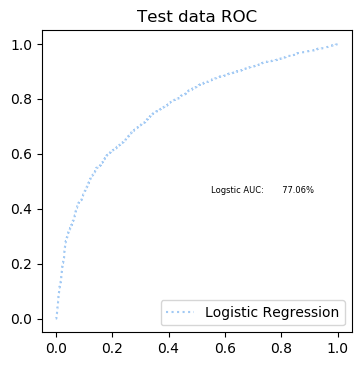

In [17]:
fp_l, tp_l, td_l = roc_curve(y_test, y_test_pred_prob_lgt_gd)

auc_lgt = roc_auc_score(y_test, y_test_pred_prob_lgt_gd)


mpl.rcParams['figure.dpi']= 100
plt.figure(figsize=(4,4))
plt.plot(fp_l, tp_l,'b:',label='Logistic Regression')

plt.title('Test data ROC')
plt.legend(loc='lower right')
tex_lgt = 'Logstic AUC:  %10.2f%%'%(auc_lgt*100)

plt.text(0.55, 0.45, tex_lgt, fontsize=6, va='bottom')


In [ ]:

# def xgb_hyper_param(learning_rate,
#                         n_estimators,
#                         max_depth,
#                         subsample,
#                         colsample,
#                         gamma):
 
#     max_depth = int(max_depth)
#     n_estimators = int(n_estimators)
 
#     clf = xgb.XGBClassifier(
#         objective="binary:logistic",
#         learning_rate=learning_rate,
#         n_estimators=n_estimators,
#         max_depth=max_depth,
#         gamma=gamma)
#     return np.mean(cross_val_score(clf, X_train, y_train, cv=K_FOLD, scoring='roc_auc'))

# pbounds = {
#     'learning_rate': (0.01, 1.0),
#     'n_estimators': (100, 1000),
#     'max_depth': (3,10),
#     'subsample': (0.8, 1.0),  # Change for big datasets
#     'colsample': (0.8, 1.0),  # Change for datasets with lots of features
#     'gamma': (0, 5)}

# optimizer = BayesianOptimization(
#     f=xgb_hyper_param,
#     pbounds = pbounds,
#     random_state=2020
# )
# optimizer.maximize(
#     init_points=2,
#     n_iter=3
# )

In [ ]:

# xgb_clf = xgb.XGBClassifier(objective="binary:logistic",
#                         learning_rate = optimizer.max['params']['learning_rate'],
#                         n_estimators  = int(optimizer.max['params']['n_estimators']),
#                         max_depth     = int(optimizer.max['params']['max_depth']),
#                         subsample     = optimizer.max['params']['subsample'],
#                         colsample     = optimizer.max['params']['colsample'],
#                         gamma         = optimizer.max['params']['gamma'])


# xgb_clf.fit(X_train, y_train, eval_metric='auc', verbose=False,
#             eval_set=[(X_test, y_test)], early_stopping_rounds=50)

In [ ]:
# y_test_pred_prob_xgb_raw = xgb_clf.predict_proba(X_test)[:,1]

# pl, rl, tl = precision_recall_curve(y_test, y_test_pred_prob_xgb_raw)

# f1=2*pl*rl/(pl+rl)

# mpl.rcParams['figure.dpi']= 150
# plt.figure(figsize=(15,5))

# plot_precision_recall_vs_threshold(pl, rl, tl );
# plt.title('XGboost')

# txt_f1 = 'XGB F1 score:  %10.3f'%(np.nanmax(f1[:-1]))

# plt.text(0.55, 0.45, txt_f1, fontsize=12, va='top')



In [ ]:
# fp_l, tp_l, td_l = roc_curve(y_test, y_test_pred_prob_xgb_raw)

# auc_lgt = roc_auc_score(y_test, y_test_pred_prob_xgb_raw)


# mpl.rcParams['figure.dpi']= 100
# plt.figure(figsize=(4,4))
# plt.plot(fp_l, tp_l,'b:',label='XGBoost')

# plt.title('Test data ROC')
# plt.legend(loc='lower right')
# tex_lgt = 'XGB AUC:  %10.2f%%'%(auc_lgt*100)

# plt.text(0.55, 0.45, tex_lgt, fontsize=6, va='bottom')

In [ ]:
import tensorflow.keras.initializers
import statistics
import tensorflow.keras
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.layers import LeakyReLU,PReLU
from tensorflow.keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.base import clone
import keras

In [ ]:

# Define my cross_val_score
def ann_hyper_param(dropout, lr, neuronPct, neuronShrink):
    skfolds = StratifiedKFold(n_splits=K_FOLD, random_state=2019)
    scores = []
    for train_idx, val_idx in skfolds.split(X_train.values, y_train.values):
        clf = make_model(dropout, lr, neuronPct, neuronShrink) 
        X_train_folds = X_train.values[train_idx]
        y_train_folds = y_train.values[train_idx]
        X_val_fold   = X_train.values[val_idx]
        y_val_fold   = y_train.values[val_idx]
        clf.fit(X_train_folds, y_train_folds, verbose=0) 
        y_pred = clf.predict(X_val_fold)
        score = roc_auc_score(y_val_fold, y_pred)
        scores.append(score)
        keras.backend.clear_session() # clear the current model
    return statistics.mean(scores) 

def make_model(dropout, lr, neuronPct, neuronShrink):
    neuronCount = int(neuronPct * 5000)
    model = Sequential()
    layer = 0
    neuronCount
    while neuronCount>25 and layer<20:
        if layer==0:
            model.add(Dense(neuronCount, 
                            input_dim=X_train.shape[1], 
                            kernel_initializer = 'uniform',
                            activation='relu')) 
        else:
            model.add(Dense(neuronCount, kernel_initializer = 'uniform', activation='relu')) 
        model.add(Dropout(dropout))
        neuronCount *= neuronShrink
        neuronCount
        layer += 1
    model.add(Dense(1,kernel_initializer = 'uniform', activation='sigmoid')) # Output
#     model.summary()
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr), metrics=['accuracy'])
    return model



# Bounded region of parameter space
pbounds = {
           'dropout': (0.0, 0.499),
           'lr': (0.0, 0.1),
           'neuronPct': (0.01, 1),
           'neuronShrink': (0.01, 1)
          }
optimizer = BayesianOptimization(
    f=ann_hyper_param,
    pbounds=pbounds,
    random_state=2019
)
optimizer.maximize(init_points=1, n_iter=3)
optimizer.max['params']['lr']

In [ ]:

def make_model1(dropout, lr, neuronCount):
    model = Sequential()    
    model.add(Dense(neuronCount, 
                    input_dim=X_train.shape[1], 
                    kernel_initializer = 'uniform',
                    activation='relu')) 
    model.add(Dense(neuronCount*2, kernel_initializer = 'uniform', activation='relu'))   

    model.add(Dropout(dropout)) 
    model.add(Dense(1,kernel_initializer = 'uniform', activation='sigmoid')) # Output
#     model.summary()
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr), metrics=['accuracy'])
    return model



ann_clf = make_model1(dropout = 0.3, 
                    lr = 0.01,
                    neuronCount = 50 )

#best with 2 layers
# ann_clf = make_model1(dropout = 0.3, 
#                     lr = 0.01,
#                     neuronCount = 50 )


# ann_clf = make_model(dropout = optimizer.max['params']['dropout'], 
#                     lr = optimizer.max['params']['lr'],
#                     neuronPct = optimizer.max['params']['neuronPct'], 
#                     neuronShrink =optimizer.max['params']['neuronShrink'])
ann_clf.summary()

ann_clf.fit(X_train, y_train,  
            epochs=40, verbose=True)

#best
# ann_clf.fit(X_train, y_train,  
#             epochs=40, verbose=True)


In [ ]:
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
def make_model2(dropout, lr, neuronCount, top_words):
    model = Sequential()    
#     model.add(Dense(neuronCount, 
#                     input_dim=X_train.shape[1], 
#                     kernel_initializer = 'uniform',
#                     activation='relu')) 

#     model.add(Dense(neuronCount*2, kernel_initializer = 'uniform', activation='relu'))   
#    model.add(Embedding(top_words, embedding_vecor_length=32, input_length=max_review_length))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
#     model.add(Dropout(dropout)) 
    model.add(Dense(1, activation='sigmoid')) # Output
#     model.summary()
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr), metrics=['accuracy'])
    return model



max_review_length = 23
embedding_vecor_length = 32
X_train3= pd.DataFrame(X_train2).to_numpy()
X_test3= pd.DataFrame(X_test2).to_numpy()
X_train3 = sequence.pad_sequences(X_train3, maxlen=max_review_length, dtype='int32',padding='pre',truncating='pre',value=0.0)
X_test3 = sequence.pad_sequences(X_test3, maxlen=max_review_length, dtype='int32',padding='pre',truncating='pre',value=0.0)

ann_clf2 = make_model2(dropout = 0.3, 
                    lr = 0.01,
                    neuronCount = 50, 
                    top_words = 1000)

#best with 2 layers
# ann_clf = make_model1(dropout = 0.3, 
#                     lr = 0.01,
#                     neuronCount = 50 )


# ann_clf = make_model(dropout = optimizer.max['params']['dropout'], 
#                     lr = optimizer.max['params']['lr'],
#                     neuronPct = optimizer.max['params']['neuronPct'], 
#                     neuronShrink =optimizer.max['params']['neuronShrink'])
ann_clf2.summary()



ann_clf2.fit(X_train3, y_train2,  
            epochs=40, verbose=True)

#best
# ann_clf.fit(X_train, y_train,  
#             epochs=40, verbose=True)

In [ ]:
y_test_pred_prob_ann_raw = ann_clf.predict_proba(X_test)[:,0]
np.nanmax(y_test_pred_prob_ann_raw)

pl, rl, tl = precision_recall_curve(y_test, y_test_pred_prob_ann_raw)

f1=2*pl*rl/(pl+rl)

mpl.rcParams['figure.dpi']= 150
plt.figure(figsize=(15,5))

plot_precision_recall_vs_threshold(pl, rl, tl );
plt.title('ANN')

txt_f1 = 'ANN F1 score:  %10.3f'%(np.nanmax(f1[:-1]))

plt.text(0.25, 0.45, txt_f1, fontsize=12, va='top')


In [ ]:
fp_l, tp_l, td_l = roc_curve(y_test, y_test_pred_prob_ann_raw)

auc_ann = roc_auc_score(y_test, y_test_pred_prob_ann_raw)
# acc_ann = accuracy_score(y_true = y_test, y_pred = ann_clf.predict(X_test))

mpl.rcParams['figure.dpi']= 100
plt.figure(figsize=(4,4))
plt.plot(fp_l, tp_l,'b:',label='ANN')

plt.title('Test data ROC')
plt.legend(loc='lower right')
tex_lgt = 'ANN AUC:  %10.3f%%'%(auc_ann*100)


plt.text(0.55, 0.45, tex_lgt, fontsize=6, va='bottom')
# plt.text(0.55, 0.45, tex_2, fontsize=6, va='bottom')
X_train.shape[1]